In [49]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import math as math

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [76]:
szr = np.loadtxt('pre_szr.csv', delimiter=',') #load positive samples
non_szr = np.loadtxt('non_szr.csv', delimiter=',') #load negative samples

In [77]:
NUM_CYCLES = 7 #set how many k-fold iterations over the dataset we'll fit
NUM_EPOCHS = 5
BATCH_SIZE = 1000

In [78]:
#np.random.shuffle(non_szr)
num_chunks = len(non_szr) / len(szr)
print num_chunks #gives a number of chunks that will make the number of negative and non-negative samples
#be approximately equal to each other
num_chunks = int(num_chunks)
print num_chunks
non_szr = np.array_split(non_szr, num_chunks)

data = np.vstack((non_szr[num_chunks - 1], szr)) #stacks the last full chunk of negative data on the positive data
labels = np.hstack((np.zeros(len(non_szr[num_chunks - 1])), np.ones(len(szr)))) #generates labels corresponding
#to the data

X_throwaway, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=.2) #gives us test chunks
print Y_test.shape

110
110
(12297,)


In [79]:
# create model
model = Sequential()
model.add(Dense(10, input_dim=23, init='uniform', activation='sigmoid'))
model.add(Dense(10, init='uniform', activation='sigmoid'))
model.add(Dense(1, init='uniform', activation='sigmoid')) #last layer needs to be sigmoid activation (why?)

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model in batches, taking different negative data each time
for i in range(0, NUM_CYCLES):
    szr.astype(np.float32)
    
    #stack the data
    X_train = np.vstack((non_szr[i], szr))
    print X_train.shape
    #stack the labels
    Y_train = np.hstack((np.zeros(len(non_szr[i])), np.ones(len(szr))))
    print Y_train.shape
    
    model.fit(X_train, Y_train, nb_epoch=NUM_EPOCHS, batch_size=BATCH_SIZE)

(61486, 23)
(61486,)
Epoch 1/5
61486/61486 [==============================] - 2s - loss: 0.6932 - acc: 0.5010     
Epoch 2/5
61486/61486 [==============================] - 0s - loss: 0.6930 - acc: 0.5064     
Epoch 3/5
61486/61486 [==============================] - 0s - loss: 0.6926 - acc: 0.5226     
Epoch 4/5
61486/61486 [==============================] - 0s - loss: 0.6915 - acc: 0.5432     
Epoch 5/5
61486/61486 [==============================] - 0s - loss: 0.6888 - acc: 0.5483     
(61486, 23)
(61486,)
Epoch 1/5
61486/61486 [==============================] - 0s - loss: 0.6872 - acc: 0.5577     
Epoch 2/5
61486/61486 [==============================] - 0s - loss: 0.6772 - acc: 0.6100     
Epoch 3/5
61486/61486 [==============================] - 0s - loss: 0.6516 - acc: 0.7025     
Epoch 4/5
61486/61486 [==============================] - 0s - loss: 0.6067 - acc: 0.7579     
Epoch 5/5
61486/61486 [==============================] - 0s - loss: 0.5547 - acc: 0.7862     
(61486, 23)
(61486

In [80]:
# evaluate the model
scores = model.evaluate(X_train, Y_train)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

#generate prediction probabilities for ROC curve
proba = model.predict_proba(X_test, verbose=1)

10112/12297 [=======================>......] - ETA: 0s

In [81]:
def generate_results(predictions, actual):
    #This just plots the ROC curve
    false_positive_rate, true_positive_rate, thresholds = met.roc_curve(actual, predictions)
    roc_auc = met.auc(false_positive_rate, true_positive_rate)
    
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

0.796662855082


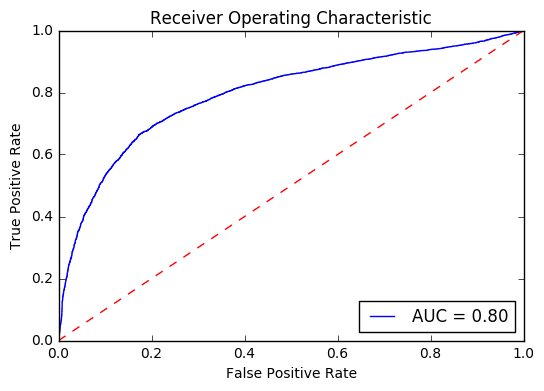

In [82]:
import sklearn.metrics as met

print met.roc_auc_score(Y_test, proba)
generate_results(proba, Y_test)